In [14]:
import os, time, segyio
from time import time
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from sklearn.model_selection import train_test_split
from skimage.metrics import structural_similarity
from sklearn.metrics import r2_score, mean_squared_error as mse_metric, mean_absolute_error as mae_metric
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score

import tensorflow as tf
import keras.backend as K
from keras import Model, Input
from keras.layers import *
from keras.optimizers import *
from keras.losses import *

In [15]:
def check_tf_gpu():
    sys_info = tf.sysconfig.get_build_info()
    version, cuda, cudnn = tf.__version__, sys_info["cuda_version"], sys_info["cudnn_version"]
    count = len(tf.config.experimental.list_physical_devices())
    print('-'*60)
    print('----------------------- VERSION INFO -----------------------')
    print('TF version: {} | # Device(s) available: {}'.format(version, count))
    print('TF Built with CUDA? {} | CUDA: {} | cuDNN: {}'.format(tf.test.is_built_with_cuda(), cuda, cudnn))
    print(tf.config.list_physical_devices()[0],'\n', tf.config.list_physical_devices()[1])
    print('-'*60+'\n')
    return None

def plot_loss(data, figsize=(5,3)):
    plt.figure(figsize=figsize)
    plt.plot(data.history['loss'], label='train')
    plt.plot(data.history['val_loss'], label='validation')
    plt.legend(); plt.grid(True, which='both')
    plt.xlabel('Epochs'); plt.ylabel('Loss')
    plt.tight_layout()
    plt.show()
    return None

In [16]:
check_tf_gpu()

------------------------------------------------------------
----------------------- VERSION INFO -----------------------
TF version: 2.19.0 | # Device(s) available: 2
TF Built with CUDA? True | CUDA: 12.5.1 | cuDNN: 9
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU') 
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
------------------------------------------------------------



***
# Data Loading

In [17]:
slb_flat = np.moveaxis(segyio.tools.cube(segyio.open('Schlumberger Synthetic model/Schlumberger_800_SLB_Force_Fault_Model_Flat_Noisy_Amplitude.segy')), -1, 1)
slb_hybrid = np.moveaxis(segyio.tools.cube(segyio.open('Schlumberger Synthetic model/Schlumberger_800_SLB_Force_Fault_Model_Hybrid_Noisy_Amplitude.segy')), -1, 1)
slb_circular = np.moveaxis(segyio.tools.cube(segyio.open('Schlumberger Synthetic model/Schlumberger_800_SLB_Force_Fault_Model_Circular_Noisy_Amplitude.segy')), -1, 1)
slb_fault = np.moveaxis(segyio.tools.cube(segyio.open('Schlumberger Synthetic model/Schlumberger_800_SLB_Force_Fault_Model_IsFault.segy')), -1, 1)
print('Schlumberger Force Fault - Flat: {} | Hybrid: {} | Circular: {} | Fault: {}'.format(slb_flat.shape, slb_hybrid.shape, slb_circular.shape, slb_fault.shape))

Schlumberger Force Fault - Flat: (151, 901, 301) | Hybrid: (151, 901, 301) | Circular: (151, 901, 301) | Fault: (151, 901, 301)


In [18]:
equinor_pp = np.rot90(segyio.tools.cube(segyio.open('Equinor Synthetic model/issap20_Pp.sgy', xline=181)), axes=(1,2), k=3)
equinor_ai = np.rot90(segyio.tools.cube(segyio.open('Equinor Synthetic model/issap20_AI.sgy', xline=181)), axes=(1,2), k=3)
equinor_fault = np.rot90(segyio.tools.cube(segyio.open('Equinor Synthetic model/issap20_Fault.sgy', xline=181)), axes=(1,2), k=3)
print('Equinor - PP: {} | AI: {} | Fault: {}'.format(equinor_pp.shape, equinor_ai.shape, equinor_fault.shape))

Equinor - PP: (101, 751, 589) | AI: (101, 751, 589) | Fault: (101, 751, 589)


In [19]:
ff = np.load('faults.npz')
fomel_data, fomel_faults, fomel_test = ff['data'], ff['labels'], ff['test']
n_data, n_dim = fomel_data.shape[0], fomel_data.shape[1]
print('Fomel - Data: {} | Labels: {} | Test: {}'.format(fomel_data.shape, fomel_faults.shape, fomel_test.shape))

Fomel - Data: (2000, 128, 128) | Labels: (2000, 128, 128) | Test: (100, 256, 640)


***
# Visualization

Schlumberger Force Fault Model - Flat: (151, 901, 301) | Hybrid: (151, 901, 301) | Circular: (151, 901, 301) | Fault: (151, 901, 301)


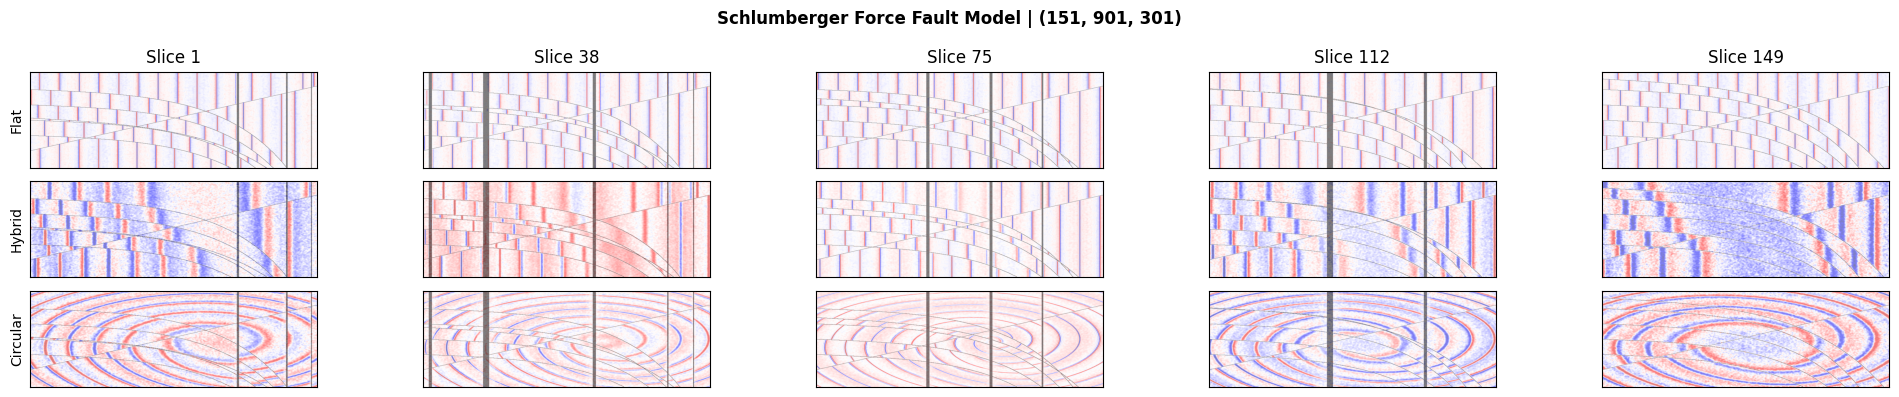

In [20]:
print('Schlumberger Force Fault Model - Flat: {} | Hybrid: {} | Circular: {} | Fault: {}'.format(slb_flat.shape, slb_hybrid.shape, slb_circular.shape, slb_fault.shape))

my_cmap = 'seismic'
fig, axs = plt.subplots(3, 5, figsize=(20,4), sharex=True, sharey=True)
for j in range(5):
    k = j * 37 + 1
    ax1, ax2, ax3 = axs[0,j], axs[1,j], axs[2,j]
    ax1.imshow(slb_flat[k].T, cmap=my_cmap)
    ax2.imshow(slb_hybrid[k].T, cmap=my_cmap)
    ax3.imshow(slb_circular[k].T, cmap=my_cmap)
    [a.imshow(slb_fault[k].T, cmap='binary', vmin=0, vmax=1, alpha=0.5) for a in axs[:,j]]
    [a.set(xticks=[], yticks=[], title='Slice {}'.format(k) if i==0 else '') for i, a in enumerate(axs[:, j])]
    [a.set_ylabel(['Flat','Hybrid','Circular'][i], color='k') for i, a in enumerate(axs[:,0])]
plt.suptitle('Schlumberger Force Fault Model | {}'.format(slb_fault.shape), fontweight='bold')
plt.tight_layout()
plt.savefig('figures/SLB_model.png', dpi=300)
plt.show()

Equinor Synthetic Model - PP: (101, 751, 589) | AI: (101, 751, 589) | Fault: (101, 751, 589)


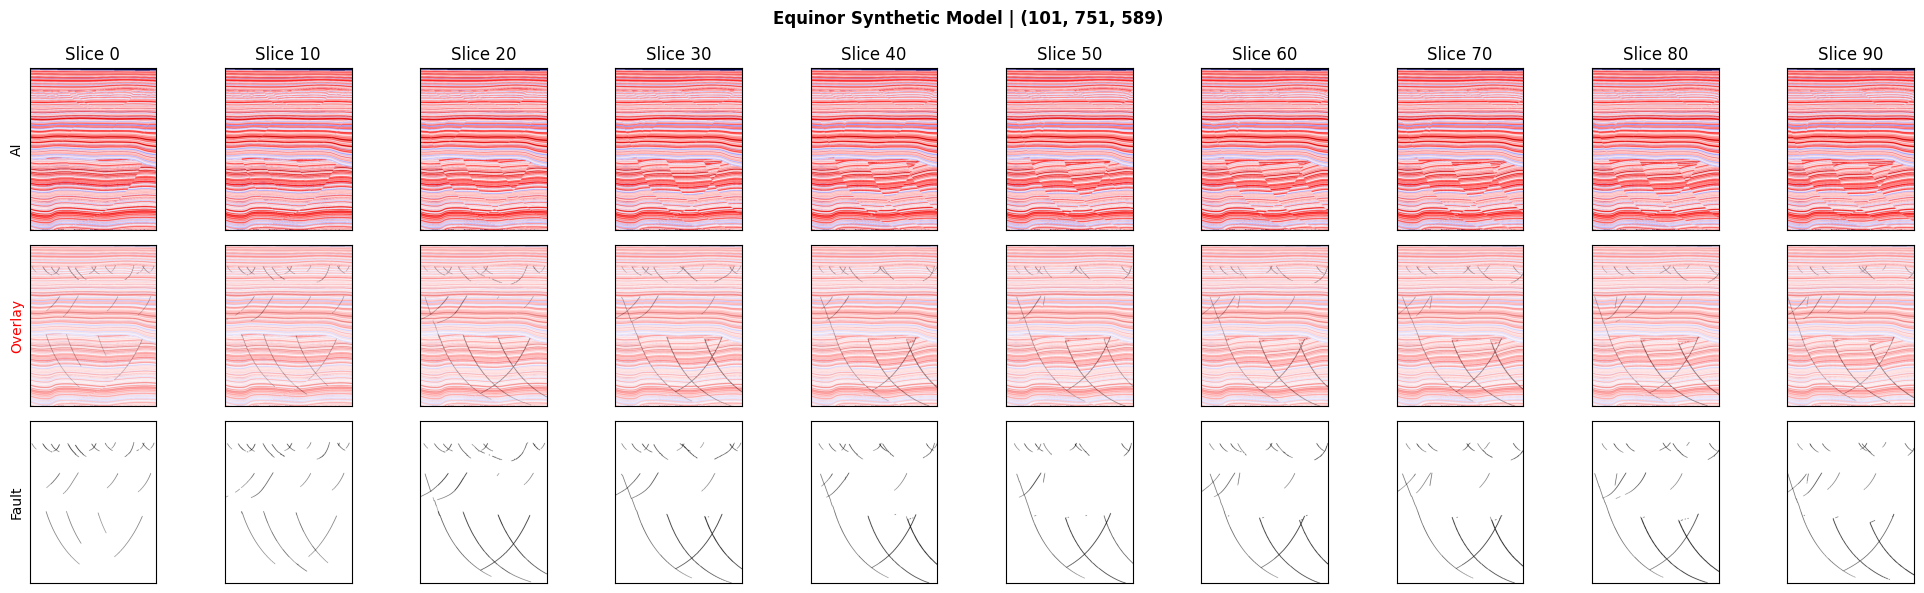

In [21]:
print('Equinor Synthetic Model - PP: {} | AI: {} | Fault: {}'.format(equinor_pp.shape, equinor_ai.shape, equinor_fault.shape))

my_cmap = 'seismic'
fig, axs = plt.subplots(3, 10, figsize=(20, 6), sharex=True, sharey=True)
for j in range(10):
    k = j * 10
    ax1, ax2, ax3 = axs[0, j], axs[1, j], axs[2, j]
    ax1.imshow(equinor_ai[k], cmap=my_cmap)
    ax2.imshow(equinor_ai[k], cmap=my_cmap)
    ax2.imshow(equinor_fault[k], cmap='binary', vmin=0, vmax=1, alpha=0.5)
    ax3.imshow(equinor_fault[k], cmap='binary', vmin=0, vmax=1)
    [a.set(xticks=[], yticks=[], title='Slice {}'.format(k) if i==0 else '') for i, a in enumerate(axs[:, j])]
    [a.set_ylabel(['AI','Overlay','Fault'][i], color=['k','r','k'][i]) for i, a in enumerate(axs[:,0])]
plt.suptitle('Equinor Synthetic Model | {}'.format(equinor_fault.shape), fontweight='bold')
plt.tight_layout()
plt.savefig('figures/Equinor_model.png', dpi=300)
plt.show()

Fomel Faults - Data: (2000, 128, 128) | Labels: (2000, 128, 128) | Test: (100, 256, 640)


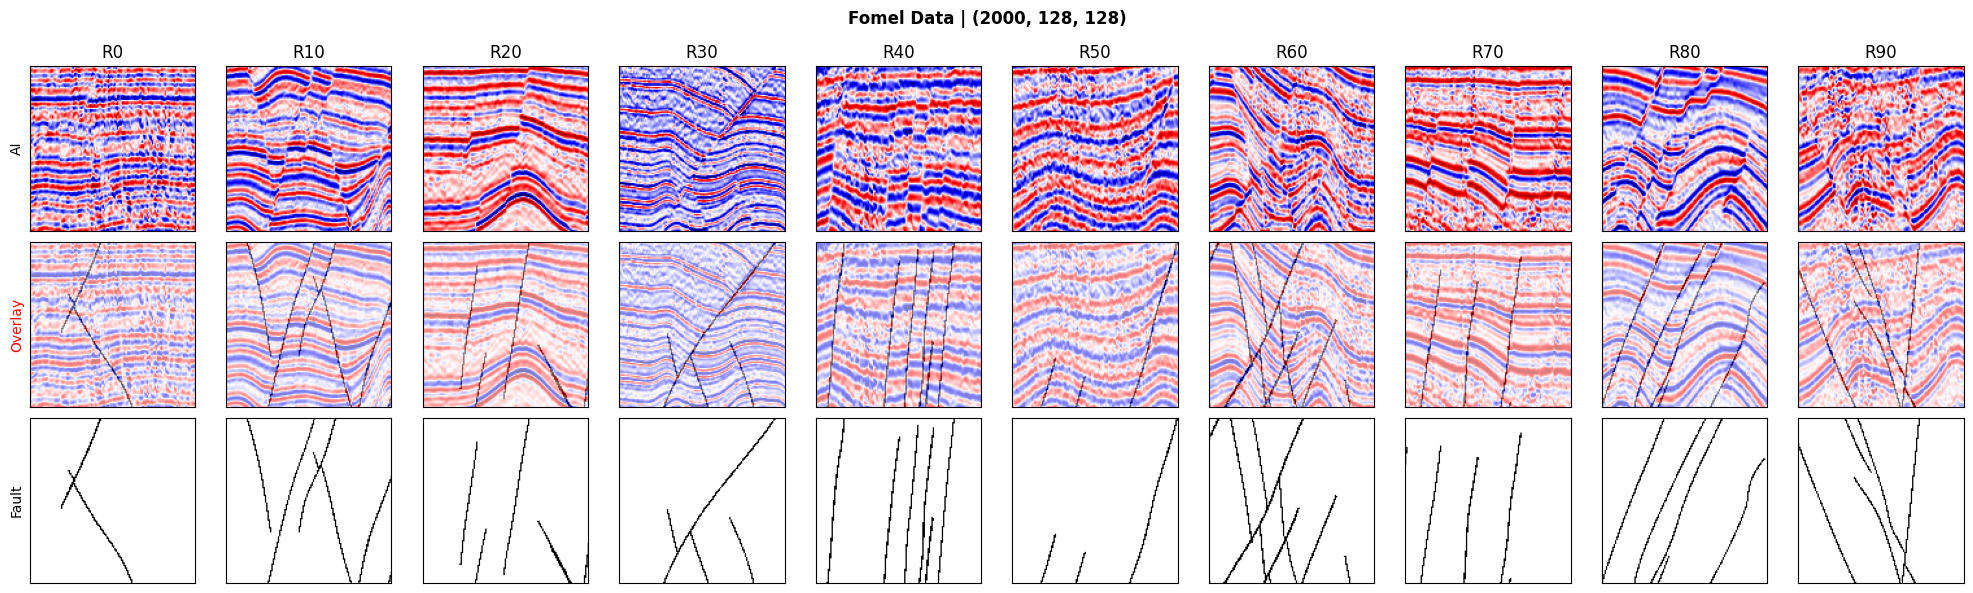

In [22]:
print('Fomel Faults - Data: {} | Labels: {} | Test: {}'.format(fomel_data.shape, fomel_faults.shape, fomel_test.shape))

my_cmap = 'seismic'
fig, axs = plt.subplots(3, 10, figsize=(20, 6), sharex=True, sharey=True)
for j in range(10):
    k = j * 10
    ax1, ax2, ax3 = axs[0, j], axs[1, j], axs[2, j]
    ax1.imshow(fomel_data[k], cmap=my_cmap)
    ax2.imshow(fomel_data[k], cmap=my_cmap)
    ax2.imshow(fomel_faults[k], cmap='binary', vmin=0, vmax=1, alpha=0.5)
    ax3.imshow(fomel_faults[k], cmap='binary', vmin=0, vmax=1)
    [a.set(xticks=[], yticks=[], title='R{}'.format(k) if i==0 else '') for i, a in enumerate(axs[:, j])]
    [a.set_ylabel(['AI','Overlay','Fault'][i], color=['k','r','k'][i]) for i, a in enumerate(axs[:,0])]
plt.suptitle('Fomel Data | {}'.format(fomel_faults.shape), fontweight='bold')
plt.tight_layout()
plt.savefig('figures/Fomel_model.png', dpi=300)
plt.show()

***
# Automatic Fault Picking - model training and predictions

In [33]:
def plot_predictions(x, ytrue, ypred, ncols:int=5, mult:int=10, suptitle:str='Results', figsize=(12,7), cmaps=['seismic', 'viridis'], vmin=0, vmax=1, alpha=0.33, fname:str=None):
    _, axs = plt.subplots(4, ncols, figsize=figsize, sharex=True, sharey=True)
    for j in range(ncols):
        k = j * mult
        ax1, ax2, ax3, ax4 = axs[:,j]
        ax1.set(title='R{}'.format(k))
        ax1.imshow(x[k], cmap=cmaps[0], vmin=vmin, vmax=vmax)
        ax1.imshow(ytrue[k], cmap='binary', vmin=0, vmax=1, alpha=alpha)
        ax2.imshow(ytrue[k], cmap=cmaps[1], vmin=vmin, vmax=vmax)
        ax3.imshow(ypred[k], cmap=cmaps[1], vmin=0, vmax=1)
        ax4.imshow(x[k], cmap=cmaps[0], vmin=vmin, vmax=vmax)
        ax4.imshow(ypred[k], cmap='binary', vmin=0, vmax=1, alpha=alpha)
        [a.set_ylabel(['AI (input)', 'Fault (true)', 'Fault (pred)', 'Overlay (pred)'][i], color=['k', 'r', 'b', 'b'][i]) for i, a in enumerate(axs[:,0])]
    plt.suptitle(suptitle)
    plt.tight_layout()
    plt.savefig('{}.png'.format(fname), dpi=300) if fname is not None else None
    plt.show()
    return None

In [24]:
def error_metrics(train_true, train_pred, test_true, test_pred, print_metrics:bool=False, data_range=1.0, multichannel=False, average='macro', zero_division=0):
    ntrain, ntest = train_true.shape[0], test_true.shape[0]
    r2_train = r2_score(train_true.reshape(ntrain,-1), train_pred.reshape(ntrain,-1))
    r2_test = r2_score(test_true.reshape(ntest,-1), test_pred.reshape(ntest,-1))
    print('R2       - train: {:.3f} | test: {:.3f}'.format(r2_train, r2_test)) if print_metrics else None
    
    mse_train = mse_metric(train_true.reshape(ntrain,-1), train_pred.reshape(ntrain,-1))
    mse_test = mse_metric(test_true.reshape(ntest,-1), test_pred.reshape(ntest,-1))
    print('MSE      - train: {:.3f} | test: {:.3f}'.format(mse_train, mse_test)) if print_metrics else None
    
    mae_train = mae_metric(train_true.reshape(ntrain,-1), train_pred.reshape(ntrain,-1))
    mae_test = mae_metric(test_true.reshape(ntest,-1), test_pred.reshape(ntest,-1))
    print('MAE      - train: {:.3f} | test: {:.3f}'.format(mae_train, mae_test)) if print_metrics else None

    f1_train = 100 * f1_score(train_true.reshape(ntrain,-1), train_pred.reshape(ntrain,-1), average=average, zero_division=zero_division)
    f1_test = 100 * f1_score(test_true.reshape(ntest,-1), test_pred.reshape(ntest,-1), average=average, zero_division=zero_division)
    print('F1       - train: {:.3f} | test: {:.3f}'.format(f1_train, f1_test)) if print_metrics else None

    ssim_train = 100 * structural_similarity(train_true.squeeze(), train_pred.squeeze(), data_range=data_range, multichannel=multichannel)
    ssim_test = 100 * structural_similarity(test_true.squeeze(), test_pred.squeeze(), data_range=data_range, multichannel=multichannel)
    print('SSIM     - train: {:.3f} | test: {:.3f}'.format(ssim_train, ssim_test)) if print_metrics else None
    
    metrics = pd.DataFrame({'R2': [r2_train, r2_test],
        'MSE': [mse_train, mse_test],
        'MAE': [mae_train, mae_test],
        'F1': [f1_train, f1_test],
        'SSIM': [ssim_train, ssim_test],
    }, index=['Train', 'Test']).T
    return metrics

In [25]:
def make_model():
    K.clear_session()
    
    def conv_block(inp, filt, kern=(3,3), pool=(2,2), pad='same'):
        _ = Conv2D(filters=filt, kernel_size=kern, padding=pad)(inp)
        _ = BatchNormalization()(_)
        _ = Activation('relu')(_)
        _ = MaxPooling2D(pool_size=pool)(_)
        return _
    
    def deconv_block(inp, filt, kern=(3,3), pool=(2,2), pad='same'):
        _ = Conv2D(filters=filt, kernel_size=kern, padding=pad)(inp)
        _ = BatchNormalization()(_)
        _ = Activation('relu')(_)
        _ = UpSampling2D(size=pool)(_)
        return _
    
    inp = Input(shape=(None,None,1))
    # encoder
    x = conv_block(inp, 16)
    x = conv_block(x, 64)
    x = conv_block(x, 128)
    x = conv_block(x, 256)
    # decoder
    x = deconv_block(x, 256)
    x = deconv_block(x, 128)
    x = deconv_block(x, 64)
    x = deconv_block(x, 16)
    # model
    out = Conv2D(filters=1, kernel_size=(3,3), padding='same', activation='linear')(x)
    return Model(inp, out, name='faultAE')    

In [46]:
opt = AdamW(learning_rate=1e-3, weight_decay=1e-6)
criterion = MeanSquaredError()
epochs, batch, val_split = 200, 16, 0.2

***
### SLB Force

In [41]:
# reshape
X_flat = np.moveaxis(np.pad(slb_flat, ((0,0),(62,61),(0,0)), mode='constant', constant_values=0)[...,23:-22].reshape(-1, 256, 4, 256), 2, 1).reshape(-1, 256, 256, 1)[4:]
X_hybrid = np.moveaxis(np.pad(slb_hybrid, ((0,0),(62,61),(0,0)), mode='constant', constant_values=0)[...,23:-22].reshape(-1, 256, 4, 256), 2, 1).reshape(-1, 256, 256, 1)[4:]
X_circular = np.moveaxis(np.pad(slb_circular, ((0,0),(62,61),(0,0)), mode='constant', constant_values=0)[...,23:-22].reshape(-1, 256, 4, 256), 2, 1).reshape(-1, 256, 256, 1)[4:]
Y_faults = np.moveaxis(np.pad(slb_fault, ((0,0),(62,61),(0,0)))[...,23:-22].reshape(-1, 256, 4, 256), 2, 1).reshape(-1, 256, 256, 1)[4:]

X_data = np.concatenate([X_flat, X_hybrid, X_circular], axis=0)
Y_data = np.concatenate([Y_faults, Y_faults, Y_faults], axis=0)

# normalize
X_data = (X_data - X_data.min()) / (X_data.max() - X_data.min())
Y_data = (Y_data - Y_data.min()) / (Y_data.max() - Y_data.min())

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=1/6)
print('Train - X: {} | Y: {}\nTest  - X: {}  | Y: {}'.format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))

Train - X: (1500, 256, 256, 1) | Y: (1500, 256, 256, 1)
Test  - X: (300, 256, 256, 1)  | Y: (300, 256, 256, 1)


# of parameters: 1,350,465 | Training time: 6.86 min


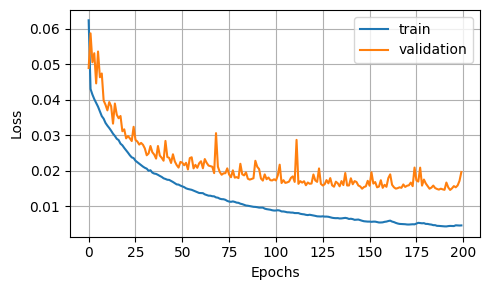

In [ ]:
ae = make_model()
ae.compile(optimizer=opt, metrics=['mse'], loss=criterion)
start = time()
fit = ae.fit(x=X_train, y=y_train,
             epochs = epochs,
             batch_size = batch,
             validation_split = val_split,
             shuffle = True,
             verbose = 0)
print('# of parameters: {:,} | Training time: {:.2f} min'.format(ae.count_params(), (time()-start)/60))
plot_loss(fit)

In [43]:
y_train_pred = ae.predict(X_train, verbose=0).squeeze()
y_test_pred = ae.predict(X_test, verbose=0).squeeze()

y_train_pred = (y_train_pred - y_train_pred.min()) / (y_train_pred.max() - y_train_pred.min())
y_test_pred = (y_test_pred - y_test_pred.min()) / (y_test_pred.max() - y_test_pred.min())

y_train_pred = np.where(y_train_pred > 0.5, 1, 0)
y_test_pred = np.where(y_test_pred > 0.5, 1, 0)

print('Pred - train: {} | test: {}'.format(y_train_pred.shape, y_test_pred.shape))
print('Train - min: {:.3f} | max: {:.3f}'.format(y_train_pred.min(), y_train_pred.max()))
print('Test  - min: {:.3f} | max: {:.3f}'.format(y_test_pred.min(), y_test_pred.max()))

Pred - train: (1500, 256, 256) | test: (300, 256, 256)
Train - min: 0.000 | max: 1.000
Test  - min: 0.000 | max: 1.000


In [44]:
metrics = error_metrics(y_train, y_train_pred, y_test, y_test_pred)
metrics

Train       Test
R2     0.592323   0.384392
MSE    0.018330   0.025122
MAE    0.018330   0.025122
F1    66.196678  55.029358
SSIM  74.369435  66.143668

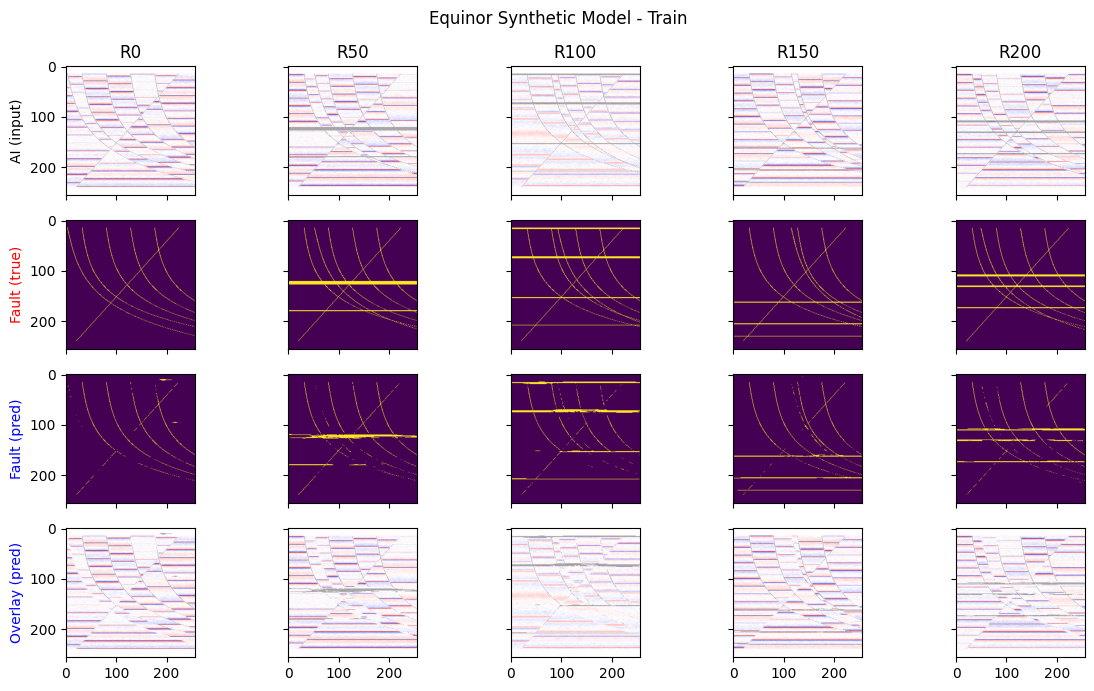

In [45]:
plot_predictions(X_train, y_train, y_train_pred, suptitle='Equinor Synthetic Model - Train', mult=50, fname='figures/SLB_train')
plot_predictions(X_test, y_test, y_test_pred, suptitle='Equinor Synthetic Model - Test', mult=10, fname='figures/SLB_test')

***
### Equinor Synthetic

In [36]:
# reshape
X_data = np.moveaxis(np.pad(equinor_ai, ((0,0),(8,9),(0,0)), mode='constant', constant_values=0)[:,:,38:-39].reshape(-1, 3, 256, 512).reshape(-1,256,256,2), -1, 1).reshape(-1,256,256,1)
Y_data = np.moveaxis(np.pad(equinor_fault, ((0,0),(8,9),(0,0)), mode='constant', constant_values=0)[:,:,38:-39].reshape(-1, 3, 256, 512).reshape(-1,256,256,2), -1, 1).reshape(-1,256,256,1)

# normalize
X_data = (X_data - X_data.min()) / (X_data.max() - X_data.min())
Y_data = (Y_data - Y_data.min()) / (Y_data.max() - Y_data.min())

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.174)
n_train, n_test = X_train.shape[0], X_test.shape[0]
print('Train - X: {} | Y: {}\nTest  - X: {} | Y: {}'.format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))

Train - X: (500, 256, 256, 1) | Y: (500, 256, 256, 1)
Test  - X: (106, 256, 256, 1) | Y: (106, 256, 256, 1)


# of parameters: 1,350,465 | Training time: 2.57 min


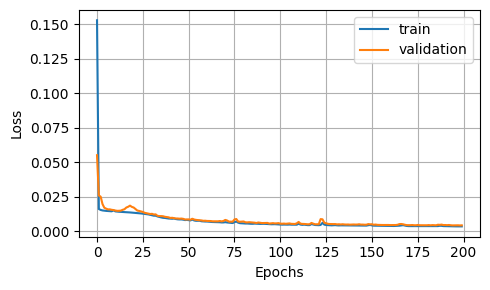

In [ ]:
ae = make_model()
ae.compile(optimizer=opt, metrics=['mse'], loss=criterion)
start = time()
fit = ae.fit(x=X_train, y=y_train,
             epochs = epochs,
             batch_size = batch,
             validation_split = val_split,
             shuffle = True,
             verbose = 0)
print('# of parameters: {:,} | Training time: {:.2f} min'.format(ae.count_params(), (time()-start)/60))
plot_loss(fit)

In [38]:
y_train_pred = ae.predict(X_train, verbose=0).squeeze()
y_test_pred = ae.predict(X_test, verbose=0).squeeze()

y_train_pred = (y_train_pred - y_train_pred.min()) / (y_train_pred.max() - y_train_pred.min())
y_test_pred = (y_test_pred - y_test_pred.min()) / (y_test_pred.max() - y_test_pred.min())

y_train_pred = np.where(y_train_pred > 0.5, 1, 0)
y_test_pred = np.where(y_test_pred > 0.5, 1, 0)

print('Pred - train: {} | test: {}'.format(y_train_pred.shape, y_test_pred.shape))
print('Train - min: {:.3f} | max: {:.3f}'.format(y_train_pred.min(), y_train_pred.max()))
print('Test  - min: {:.3f} | max: {:.3f}'.format(y_test_pred.min(), y_test_pred.max()))

Pred - train: (500, 256, 256) | test: (106, 256, 256)
Train - min: 0.000 | max: 1.000
Test  - min: 0.000 | max: 1.000


In [39]:
metrics = error_metrics(y_train, y_train_pred, y_test, y_test_pred)
metrics

Train       Test
R2     0.723247   0.762644
MSE    0.004764   0.005536
MAE    0.004764   0.005536
F1    60.172192  38.222573
SSIM  87.399121  86.518052

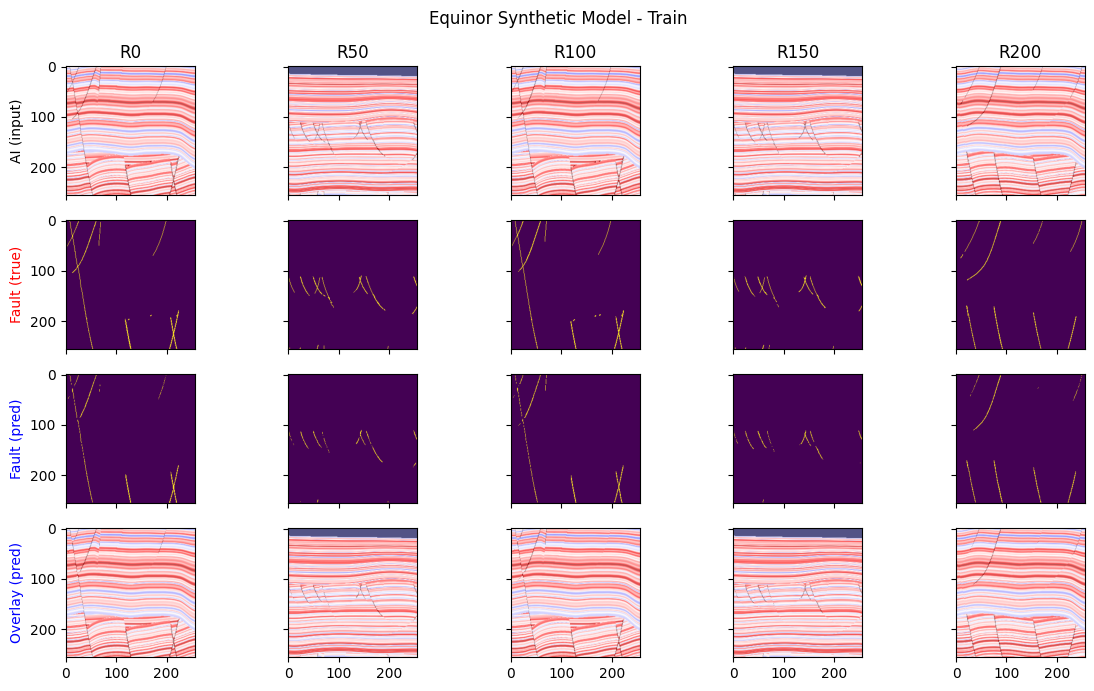

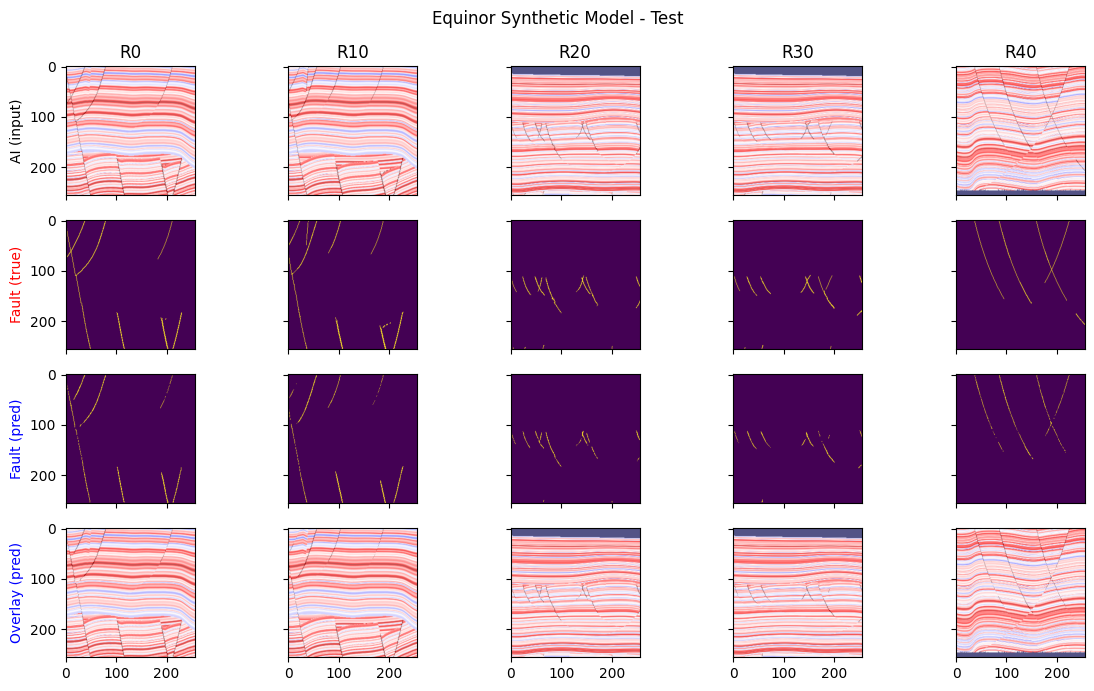

In [40]:
plot_predictions(X_train, y_train, y_train_pred, suptitle='Equinor Synthetic Model - Train', mult=50, fname='figures/Equinor_train')
plot_predictions(X_test, y_test, y_test_pred, suptitle='Equinor Synthetic Model - Test', mult=10, fname='figures/Equinor_test')

***
## Fomel faults

In [27]:
# normalize
X_data = (fomel_data - fomel_data.min()) / (fomel_data.max() - fomel_data.min())
Y_data = (fomel_faults - fomel_faults.min()) / (fomel_faults.max() - fomel_faults.min())

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.20)
n_train, n_test = X_train.shape[0], X_test.shape[0]
print('Train - X: {} | Y: {}\nTest  - X: {} | Y: {}'.format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))

Train - X: (1600, 128, 128) | Y: (1600, 128, 128)
Test  - X: (400, 128, 128) | Y: (400, 128, 128)


In [ ]:
ae = make_model()
ae.compile(optimizer=opt, metrics=['mse'], loss=criterion)
start = time()
fit = ae.fit(x=X_train, y=y_train,
             epochs = epochs,
             batch_size = batch,
             validation_split = val_split,
             shuffle = True,
             verbose = 0)
print('# of parameters: {:,} | Training time: {:.2f} min'.format(ae.count_params(), (time()-start)/60))
plot_loss(fit)

I0000 00:00:1750901287.517521   11737 service.cc:152] XLA service 0x786f04003540 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750901287.517563   11737 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-06-25 20:28:07.648507: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1750901288.254718   11737 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1750901294.354199   11737 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


# of parameters: 1,350,465 | Training time: 2.91 min


In [29]:
y_train_pred = ae.predict(X_train, verbose=0).squeeze()
y_test_pred = ae.predict(X_test, verbose=0).squeeze()

y_train_pred = (y_train_pred - y_train_pred.min()) / (y_train_pred.max() - y_train_pred.min())
y_test_pred = (y_test_pred - y_test_pred.min()) / (y_test_pred.max() - y_test_pred.min())

y_train_pred = np.where(y_train_pred > 0.5, 1, 0)
y_test_pred = np.where(y_test_pred > 0.5, 1, 0)

print('Pred - train: {} | test: {}'.format(y_train_pred.shape, y_test_pred.shape))
print('Train - min: {:.3f} | max: {:.3f}'.format(y_train_pred.min(), y_train_pred.max()))
print('Test  - min: {:.3f} | max: {:.3f}'.format(y_test_pred.min(), y_test_pred.max()))

Pred - train: (1600, 128, 128) | test: (400, 128, 128)
Train - min: 0.000 | max: 1.000
Test  - min: 0.000 | max: 1.000


In [30]:
metrics = error_metrics(y_train, y_train_pred, y_test, y_test_pred)
metrics

Train       Test
R2     0.642257  -0.002161
MSE    0.011734   0.031905
MAE    0.011734   0.031905
F1    80.140014  26.615160
SSIM  78.411887  33.824511

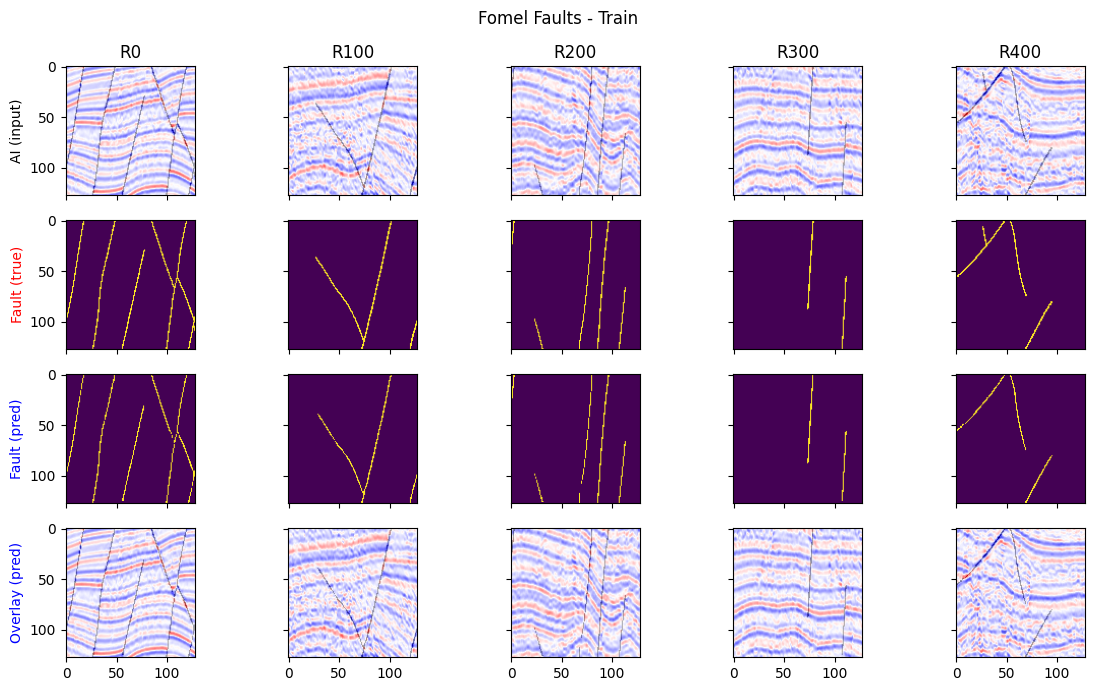

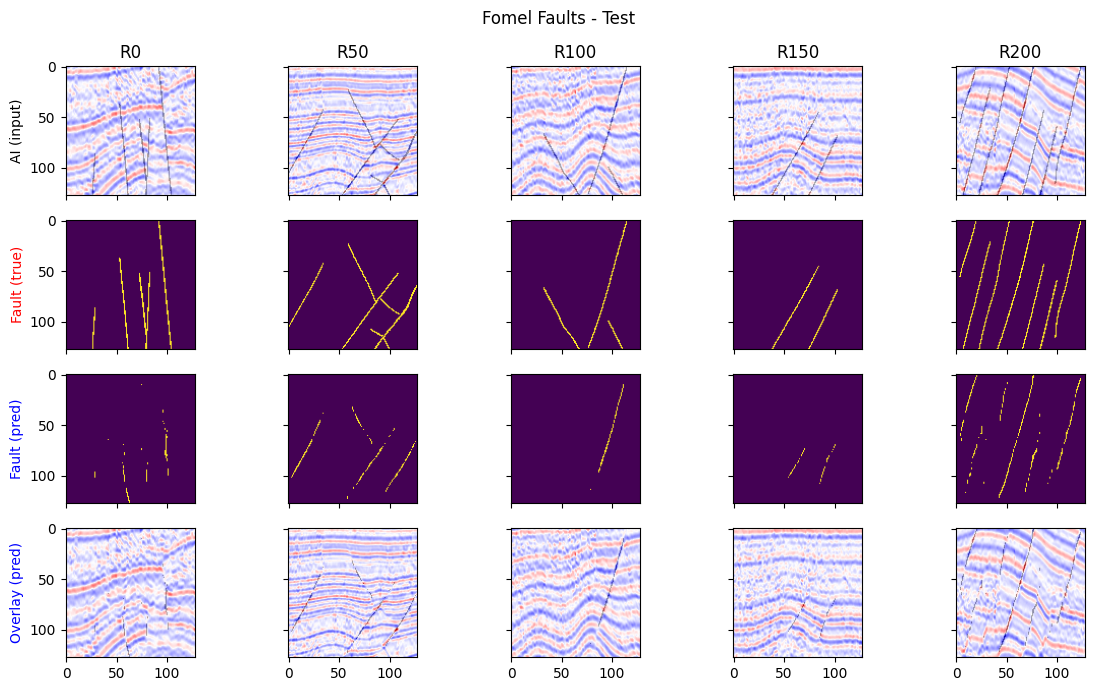

In [35]:
plot_predictions(X_train, y_train, y_train_pred, suptitle='Fomel Faults - Train', mult=100, fname='figures/Fomel_train')
plot_predictions(X_test, y_test, y_test_pred, suptitle='Fomel Faults - Test', mult=50, fname='figures/Fomel_test')

***
# END